# Slide model with nonlinear return mapping

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mayavi import mlab
#mlab.init_notebook()

## Material parameters

In [2]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True, nonnegative=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)
m = sp.Symbol('m', real=True)

## Control parameter

In [3]:
sigma_N = sp.Symbol('sigma_N', real=True)

## State variables

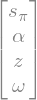

In [4]:
s = sp.Symbol('s', real=True)
omega = sp.Symbol('omega', real=True, nonnegative=True)
omega.is_nonnegative
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)
SV = sp.Matrix([s_pi, alpha, z, omega])
SV

In [5]:
dot_lambda = sp.Symbol(r'\dot{\lambda}', real=True, nonnegative=True)

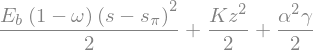

In [6]:
rho_phi = sp.Rational(1,2)* ( (1-omega)*E_b*(s-s_pi)**2 + gamma * alpha**2 + K * z**2)
rho_phi

## Thermodynamic forces

In [7]:
tau = sp.Symbol('tau', real=True)
tau_pi = sp.Symbol(r'tau_pi', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y = sp.Symbol('Y', real=True)
TF = [tau_pi, X, Z, Y] 

## Threshold 

Define effective stresses as a function of the apparent stress and damage.  Note that $\tau_\pi = \tau$.

In [8]:
tau_eff = sp.Function(r'\tau^{\mathrm{eff}}')(tau_pi, omega)
Q = sp.Function('Q')(tau_eff,X)
tau_eff

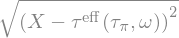

In [9]:
norm_Q = sp.sqrt(Q*Q)
sp.simplify(norm_Q.subs(Q,tau_eff-X))

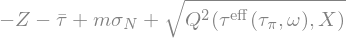

In [10]:
f = norm_Q - Z - tau_bar + m * sigma_N 
f

In [11]:
subs_Q = {Q: tau_eff - X}

In [12]:
subs_tau_eff = {tau_eff: tau_pi / (1-omega)}

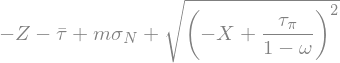

In [13]:
f_TF = f.subs(subs_Q).subs(subs_tau_eff)
f_TF

In [14]:
grad_f = sp.Matrix([ f.diff(tf) for tf in  TF ])

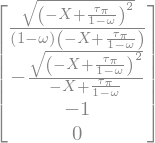

In [15]:
grad_f_TF = grad_f.subs(subs_Q).subs(subs_tau_eff).doit()
grad_f_TF

**Plot the threshold function**: for changing damage $\omega \in (0,1)$. 

In [16]:
def anim_levelset(get_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:80j, ymin:ymax:80j, zmin:zmax:80j]
    f_args = tuple(grid_args)+(0.00001,)
    f_val = get_f(*f_args)
    contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(1, 0, 0)
    )
    xl, yl, zl = labels
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            contour.mlab_source.scalars = get_f(*tuple(grid_args)+(omega_val,))
            yield

    anim()
    mlab.show()

In [17]:
if False:
    subs_f_TF_data = ({m:0, tau_bar:10})
    get_f = sp.lambdify(
        (tau_pi, X, Z, omega), 
        f_TF.subs(subs_f_TF_data), 'numpy')
    anim_levelset(get_f)

## Flow potential

In [18]:
Psi = sp.Function('\Psi')(Y,omega)

In [19]:
subs_Psi = {Psi: S* (1-omega)**c / (r+1) * (Y/S)**(r+1)}

In [20]:
psi = f + Psi

In [21]:
psi_TF = psi.subs(subs_Q).subs(subs_tau_eff).subs(subs_Psi)

In [22]:
if False:
    subs_psi_data = {tau_bar:10, m:0, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        [tau_pi, X, Y, omega],
        psi_TF.subs(subs_psi_data), 'numpy')
    anim_levelset(get_psi, zrange=(-10,10))

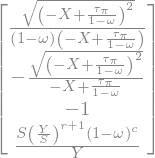

In [23]:
signs_ij = sp.diag(1,-1,-1,1)
grad_psi = sp.Matrix([psi.diff(tf) for tf in TF])
grad_psi_TF = grad_psi.subs(subs_Q).subs(subs_tau_eff).subs(subs_Psi).doit()
grad_psi_TF

In [24]:
subs_d_psi_TF = {var: val for var, val in zip(TF, grad_psi_TF)}

In [25]:
def anim_quiver3d(get_f, get_grad_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:20j, ymin:ymax:20j, zmin:zmax:20j]
    f_args = tuple(grid_args)+(tmin,)
    f_val = get_f(*f_args)
    f_contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(0, 1, 0)
    )
    x, y, z = grid_args
    psi_val = get_grad_f(*f_args)
    u, v, w = psi_val[(0,1,3),0]
    quiver = mlab.quiver3d(x,y,z,u,v,w)

    xl, yl, zl = labels 
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            f_args = tuple(grid_args)+(omega_val,)
            f_contour.mlab_source.scalars = get_f(*f_args)
            psi_val = get_grad_f(*f_args)
            u, v, w = psi_val[(0,1,3),0]
            quiver.mlab_source.u = u
            quiver.mlab_source.v = v
            quiver.mlab_source.w = w
            yield

    anim()
    mlab.show()

In [26]:
if False:
    subs_psi_data = {tau_bar:10, m:0, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        (tau_pi, X, Y, omega), 
        psi_TF.subs(subs_psi_data), 'numpy')
    get_grad_psi = sp.lambdify(
        [tau_pi, X, Y, omega], 
        grad_psi_TF.subs(subs_psi_data), 'numpy')
    anim_quiver3d(get_psi, get_grad_psi, 
                  xrange=(-30,30), yrange=(-30,30), zrange=(-5,5))

## Thermodynamic forces

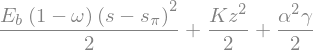

In [27]:
rho_phi

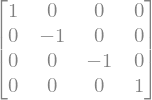

In [28]:
signs_ij

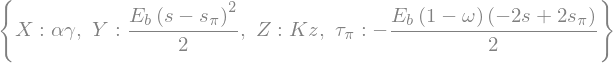

In [29]:
grad_rho_phi = sp.Matrix([rho_phi.diff(sv) for sv in SV])
subs_TF = {
  var: val for var,val in zip(TF,-signs_ij*grad_rho_phi)
}
subs_TF

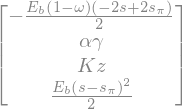

In [30]:
TF_SV = -signs_ij * grad_rho_phi
TF_SV

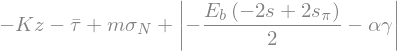

In [31]:
f_SV = f_TF.subs(subs_TF)
f_SV

Flow potential expressed in terms of the kinematic state variables

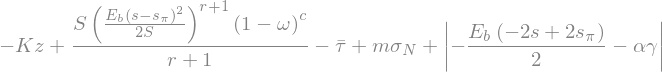

In [32]:
psi_SV = psi_TF.subs(subs_TF)
psi_SV

In [33]:
if False:
    subs_psi_SV_data = {K:1, S:10, r:0.1, c:3, m:0, E_b:1, s:0, gamma:1, tau_bar:1}
    get_psi_SV = sp.lambdify(
        (s_pi, alpha, z, omega), 
        psi_SV.subs(subs_psi_SV_data), 'numpy')
    grad_psi_SV = grad_psi_TF.subs(subs_TF)
    get_grad_psi_SV = sp.lambdify(
        (s_pi, alpha, z, omega), 
        grad_psi_SV.subs(subs_psi_SV_data), 'numpy')
    anim_quiver3d(get_psi_SV, get_grad_psi_SV, 
                  xrange=(-3,3), yrange=(-3,3), zrange=(-3,3),
                  trange=(0,0.1))

## Evolution equations

**Rates of state variables:**

In [34]:
dot_s, t = sp.symbols(r'\dot{s}, t')

In [35]:
s_t = sp.Function(r's')(t)
s_pi_t = sp.Function(r's_pi')(t)
alpha_t = sp.Function(r'alpha')(t)
z_t = sp.Function(r'z')(t)
omega_t = sp.Function(r'omega')(t)

In [36]:
def var_timify( var ):
    return sp.Function(var.name+'_t')(t)
def var_dotify( var ):
    return sp.Symbol(r'\dot{%s}' % var)

In [37]:
subs_SV_t = {
    var_timify(var) : var for var in SV
}
subs_SV_t

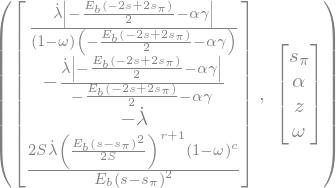

In [38]:
dot_SV_t = dot_lambda * grad_psi_TF.subs(subs_TF)
subs_dot_SV_t = {
    var_timify(var).diff(t): sp.simplify(val) 
    for var, val in zip(SV, dot_SV_t)
}
dot_SV_t, SV

## Rates of thermodynamic forces

In [39]:
subs_timify = {var: var_timify(var)
              for var in list(SV) + [s]}
subs_untimify = {var_timify(var): var
              for var in list(SV)}
subs_timify, subs_untimify

In [40]:
dot_s = sp.Symbol(r'\dot{s}')
subs_s_untimify = {var_timify(s):s, var_timify(s).diff(t): dot_s} 

Resolve the chain derivatives

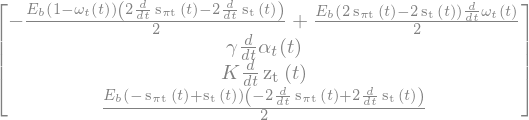

In [41]:
dot_TF = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t)
    for tf in TF ])
dot_TF

Split this to individual callable functions

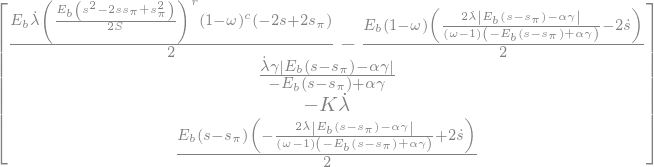

In [42]:
dot_TF_SV = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t).subs(
        subs_dot_SV_t).subs(subs_untimify).subs(subs_s_untimify)
    for tf in TF ])
dot_TF_SV

## Consistency condition

In [43]:
dot_f = sp.simplify((grad_f_TF.subs(subs_TF).T * dot_TF_SV)[0,0])

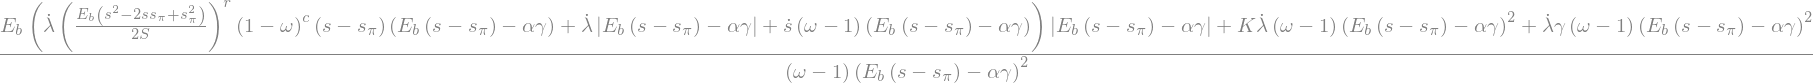

In [44]:
dot_f

## Return mapping expression

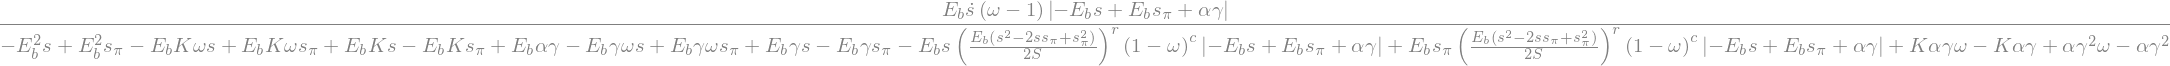

In [45]:
dot_lambda_solved = sp.solve(dot_f, dot_lambda)[0]
sp.simplify(dot_lambda_solved)

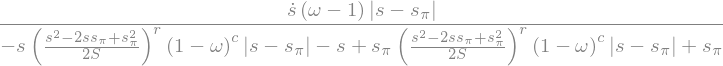

In [46]:
data_dict = {E_b:1, K:0, gamma:0} #              gamma:1, K:1, S:1, r:1, c:1, m:1, tau_bar:1, sigma_N : 0}
dot_lambda_solved.subs(data_dict)

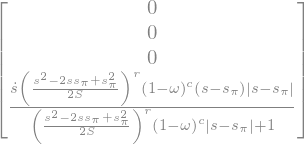

In [47]:
sp.simplify(dot_TF_SV.subs(dot_lambda, dot_lambda_solved).subs(data_dict))

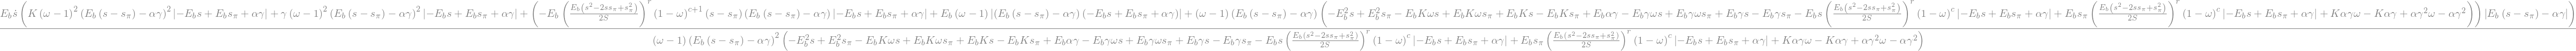

In [48]:
sp.simplify(dot_f.subs(dot_lambda, dot_lambda_solved))

## Test of consistency recovery

In [49]:
data_dict = {E_b:1, gamma:1, K:1, S:1, r:1, c:1, m:1, tau_bar:1, sigma_N : 0}

In [50]:
state_dict = {s:5, alpha:0, z:0, s_pi:1, omega:sp.Rational(1,2) }

In [51]:
dot_lambda_test = dot_lambda_solved.subs(data_dict).subs(state_dict)
dot_lambda_test

In [52]:
sp.simplify(dot_f.subs(data_dict).subs(state_dict).subs(dot_lambda, dot_lambda_test))

In [53]:
from sympy.utilities.codegen import codegen

In [54]:
#codegen(('dot_lambda', dot_lambda_state),'C89')

In [55]:
#sp.lambdify(omega, dot_lambda_state,'numpy');

# Time integration scheme

In [56]:
material_params = {
    E_b:1, gamma:0.2, K:0.1, S:0.005, r:0.001, c:1, 
    tau_bar:1, 
    m:0 
}

In [57]:
material_params = {
    E_b:1, 
    gamma: 0.6, 
    K:1, 
    S:0.6, 
    r:0.001, 
    c:1, 
    tau_bar:1, 
    m:0 
}

## Discrete evolution equations

In [58]:
s_pi_k, z_k, alpha_k = sp.symbols(
    r's_pi_k, z_k, alpha_k', real=True)
omega_k, omega_k1 = sp.symbols(
    r'omega_k, omega_k1', real=True, nonnegative=True)
s_pi_k1, z_k1, alpha_k1 = sp.symbols(
    r's_pi_k1, z_k1, alpha_k1', real=True)
dlambda_ = sp.Symbol('lambda_Delta', nonnegative=True)
subs_state_k = {s_pi: s_pi_k, alpha: alpha_k, omega: omega_k, z: z_k }
subs_state_k1 = {s_pi: s_pi_k1, alpha: alpha_k1, omega: omega_k1, z: z_k1 }

In [59]:
SV_k = sp.Matrix([sv.subs(subs_state_k) for sv in SV])
SV_k1 = sp.Matrix([sv.subs(subs_state_k1) for sv in SV])
SV_rates = dlambda_ * signs_ij * grad_psi_TF.subs(subs_TF).subs(subs_state_k1)
SV_k1_ =  SV_k + SV_rates
subs_SV_k1_ = {
    sv: expr for sv, expr in zip(SV, list(SV_k1_))
}
get_SV_k1_ = sp.lambdify(
    (s, dlambda_, SV_k, SV_k1), SV_k1_.subs(material_params), 'numpy'
)

In [60]:
S_TF_SV = signs_ij*TF_SV
S_TF_SV = -grad_rho_phi
get_TF_k = sp.lambdify(
    (s, SV_k), 
    S_TF_SV.subs({sv: val for sv, val in zip(SV,list(SV_k)) }).subs(material_params),
    'numpy'
)

In [61]:
f_SV_k1_ = f_SV.subs(subs_SV_k1_)
get_f_SV_k1_ = sp.lambdify(
    (s, dlambda_, SV_k, SV_k1), f_SV_k1_.subs(material_params), 'numpy'
)

In [62]:
d_f_SV_k1_ = f_SV_k1_.diff(dlambda_)
get_d_f_SV_k1_ = sp.lambdify(
    (s, dlambda_, SV_k, SV_k1), d_f_SV_k1_.subs(material_params), 'numpy'
)

In [63]:
subs_SV_k1_ = {
    sv: expr for sv, expr in zip(SV, list(SV_k1_))
}

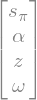

In [64]:
SV

In [65]:
TF_diag_k1 = sp.diag(*TF).subs(subs_TF).subs(subs_state_k1)

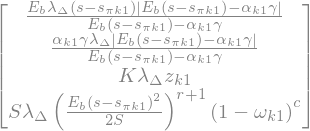

In [66]:
dE_k = sp.simplify(
    (TF_diag_k1 * SV_rates))
dE_k

In [67]:
get_dE_k = sp.lambdify(
    (s, dlambda_, SV_k1), dE_k.subs(material_params), 'numpy'
)

In [68]:
sv_k = np.array([0.1,0.05,1,0.1], dtype=np.float_)
get_dE_k(1e-6,0.1,sv_k)

array([[ 0.0099999 ],
       [-0.003     ],
       [ 0.1       ],
       [ 0.00044784]])

In [69]:
U_k = tau_pi*(s - s_pi) / 2
U_k_ = U_k.subs(subs_TF).subs(subs_state_k1)

In [70]:
get_U_k = sp.lambdify(
    (s, SV_k1), U_k_.subs(material_params), 'numpy'
)

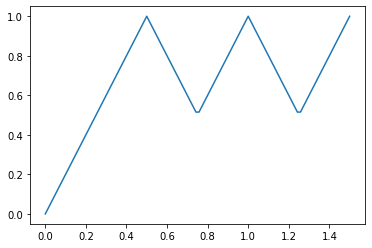

In [71]:
t_ = sp.symbols('t')
s
load_fn = sp.Piecewise(
    (2*t, t < 0.5),
    (1-2*(t-0.5), t < 0.75),
    (0.5+2*(t-0.75), t < 1),
    (1-2*(t-1), t < 1.25),
    (0.5+2*(t-1.25), t >= 1.25)
)
get_load_fn = sp.lambdify(
    t, load_fn
)
#get_load_fn = lambda t: t
t_arr = np.linspace(0,1.5,100)
s_t = get_load_fn( np.linspace(1e-9,1.5,100))
plt.plot( t_arr, s_t);

In [72]:
def get_response(s_max=12.6,n_steps=20):
    sv_n, sv_k, E_n = [
        np.zeros((len(SV),), dtype=np.float_)
                for _ in range(3)
                      ]
    U_n = 0
    E_record, U_record, sv_record, tf_record = [], [], [], []
    dlambda0 = 0
    k, k_max = 0, 2000
    t_arr = np.linspace(0,1.5,n_steps+1)
    s_t = s_max*get_load_fn(t_arr) + 1e-9
    for s_n in s_t: 
#        print('s_n',s_n)
        f0 = get_f_SV_k1_(s_n,dlambda0,sv_n,sv_k)
        norm_f0 = f0
#        print('\ns_n: %g, norm_f0: %g' % (s_n,norm_f0))
        k = 0
        while k < k_max:
            if norm_f0 < 1e-10:
                sv_n = np.copy(sv_k)
                tf_n = get_TF_k(s_n,sv_n).flatten()
                dE_n = get_dE_k(s_n, dlambda0, sv_n)
                U_n = get_U_k(s_n, sv_n)
                E_n[:] += dE_n[:,0]
                dlambda0 = 0
                sv_record.append(sv_n)
                tf_record.append(tf_n)
                E_record.append(np.copy(E_n))
                U_record.append(U_n)
                break
            df0 = get_d_f_SV_k1_(s_n,dlambda0,sv_n,sv_k)
            dlambda0 -= f0/df0
#            print('k: %g, dlambda: %g'%(k, dlambda0))
            sv_k = get_SV_k1_(s_n,dlambda0,sv_n,sv_k).flatten()
            f0 = get_f_SV_k1_(s_n,dlambda0,sv_n,sv_k)
            norm_f0 = np.fabs(f0)
            k +=1
        else:
            print('no convergence')
    return (t_arr, 
            s_t, 
            np.array(sv_record,dtype=np.float_),
            np.array(tf_record,dtype=np.float_),
            np.array(E_record,dtype=np.float_),
            np.array(U_record,dtype=np.float_))

In [73]:
from scipy.integrate import cumtrapz

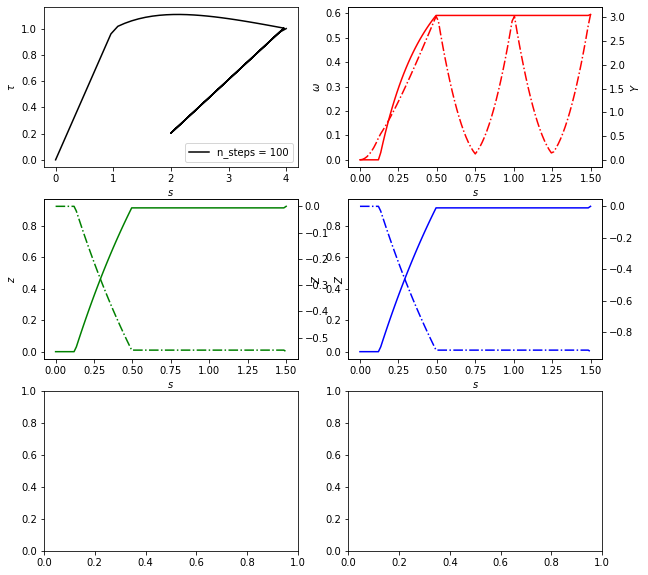

In [74]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step = 100 # np.arange(1,2)*10
s_max = 4
t_arr, s_t, sv_arr, tf_arr, E_arr, U_arr = get_response(s_max,n_step)
s_pi_, z_, alpha_, omega_ = sv_arr.T
sig_pi_, Z_, X_, Y_ = tf_arr.T
ax1.plot(s_t, sig_pi_, color='black', 
         label='n_steps = %g' % n_step)
ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
ax1.legend()
ax2.plot(t_arr, omega_, color='red', 
         label='n_steps = %g' % n_step)
ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
ax22 = ax2.twinx()
ax22.plot(t_arr, Y_, '-.', color='red', 
         label='n_steps = %g' % n_step)
ax22.set_ylabel('$Y$')
ax3.plot(t_arr, z_, color='green', 
         label='n_steps = %g' % n_step)
ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$z$')
ax33 = ax3.twinx()
ax33.plot(t_arr, Z_, '-.', color='green')
ax33.set_ylabel(r'$Z$')
ax4.plot(t_arr, alpha_, color='blue', 
         label='n_steps = %g' % n_step)
ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')
ax44 = ax4.twinx()
ax44.plot(t_arr, X_, '-.', color='blue')
plt.show()

In [75]:
xsigns_ij = np.array(signs_ij).astype(np.float_)

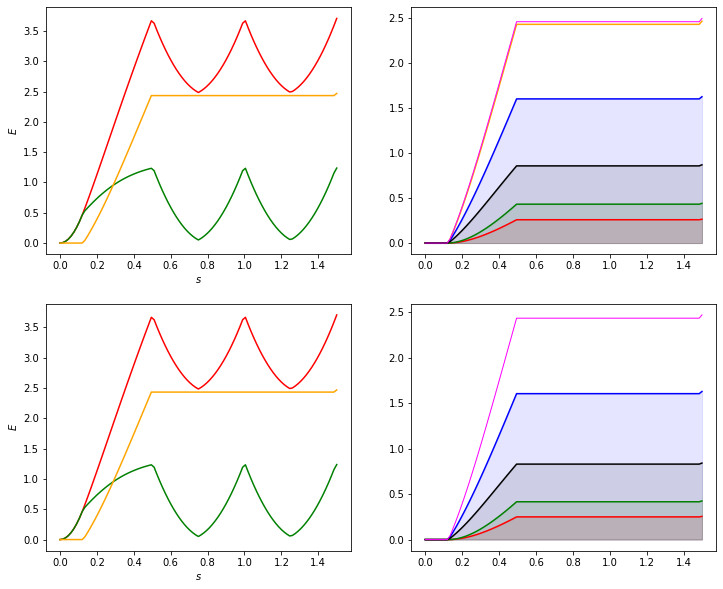

In [76]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12, 10))
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step = 100 # np.arange(1,2)*10
s_max = 4
t_arr, s_t, sv_arr, tf_arr, E_arr, U_arr = get_response(s_max,n_step)
W_arr = cumtrapz(tf_arr[:,0], s_t, initial=0)
ax1.plot(t_arr, W_arr, color='red')
ax1.plot(t_arr, U_arr, color='green')
ax1.plot(t_arr, W_arr - U_arr, color='orange')
ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$E$')
ax2.plot(t_arr, W_arr - U_arr, color='orange')
for E_, c_ in zip(E_arr.T, colors):
    ax2.plot(t_arr, E_, color=c_, 
             label=r'E_{s^\pi} = %g' % n_step)
    ax2.fill_between(t_arr, E_, 0, color=c_, 
             alpha=0.1)
ax2.plot(t_arr, E_arr[:,0] + E_arr[:,3], color='magenta', lw=1)
W2_arr = cumtrapz(tf_arr[:,0], s_t, initial=0)
U2_arr = tf_arr[:,0] * (s_t-sv_arr[:,0]) / 2.0
ax3.plot(t_arr, W2_arr, color='red')
ax3.plot(t_arr, U2_arr, color='green')
ax3.plot(t_arr, W2_arr - U2_arr, color='orange')
ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$E$')
E_i = cumtrapz(tf_arr, sv_arr, initial=0, axis=0)
E_si = np.einsum('ii,ki->ki', xsigns_ij, E_i)
for E_, c_ in zip(E_si.T, colors):
    ax4.plot(t_arr, E_, color=c_, 
             label=r'E_{s^\pi} = %g' % n_step)
    ax4.fill_between(t_arr, E_, 0, color=c_, 
             alpha=0.1)
ax4.plot(t_arr, E_i[:,0] + E_i[:,3], color='magenta', lw=1)

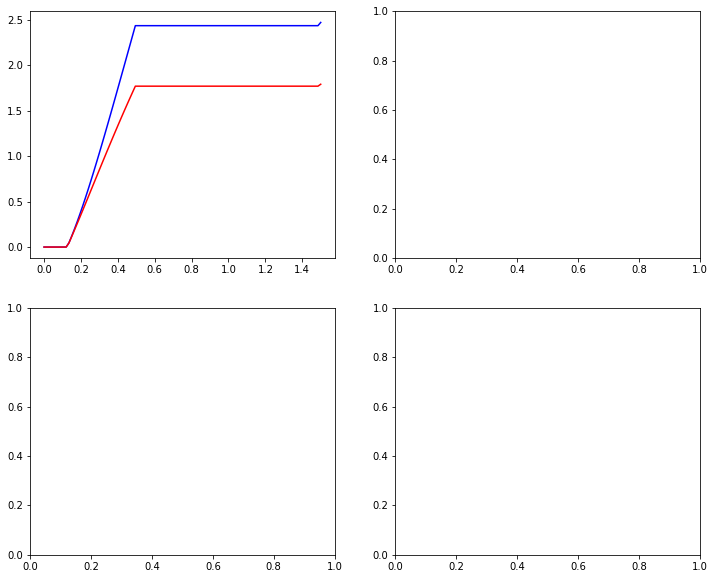

In [82]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12, 10))
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step = 100 # np.arange(1,2)*10
s_max = 4
t_arr, s_t, sv_arr, tf_arr, E_arr, U_arr = get_response(s_max,n_step)
ax1.plot(t_arr, E_i[:,0] + E_i[:,3], color='blue');
ax1.plot(t_arr, np.sum(E_i, axis=-1), color='red');